<a href="https://www.kaggle.com/code/caitlinruble/melanoma-detection-using-fastai-prototype?scriptVersionId=108283564" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### melanoma detection using FastAI - prototype
Caitlin Ortega Ruble

This notebook is going to serve as the prototype for training the deep learning model for the [siim-isic-melanoma-classification challenge on Kaggle.](https://www.kaggle.com/competitions/siim-isic-melanoma-classification/) 

Goals:
1. Recreate the cleaned data frame of training image metadata, as explored in an earlier Data Wrangling and EDA notebook [here]( https://www.kaggle.com/code/caitlinruble/melanoma-classification-eda)
2. Create a subset of negative and positive images from the training set to serve as my "proof of concept" set as I set up the modeling process with FastAI
3. Load, train and validate the miniature data set using FastAI. Basically, go through the whole process I will eventually with the full dataset, except only with a small subset of data to save on computing power and time while I'm tinkering.
4. Export the best model for deployment prototyping.



## Step 1: Load and clean train.csv as a Pandas DataFrame

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import imageio.v2 as imageio

sns.set_style('darkgrid')
plt.style.use('seaborn-notebook')

In [2]:
#read in train csv
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')

#check for any missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

image_name missing values: 0
patient_id missing values: 0
sex missing values: 65
age_approx missing values: 68
anatom_site_general_challenge missing values: 527
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0


This code block executes the data cleaning steps which were found to be necessary in the original data wrangling and cleaning notebook. The rationale behind each choice is fully explored and explained there.

In [3]:
#fill missing anatom site values with "unknown or other"
train.anatom_site_general_challenge.fillna('other or unknown', inplace=True)

#drop all rows from the train dataframe that are associated with 3 patients who are missing some data.
train.drop(train[(train['patient_id'] == 'IP_0550106') | (train['patient_id'] == 'IP_5205991') |(train['patient_id'] == 'IP_9835712')].index, inplace=True)

#check for any more missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

image_name missing values: 0
patient_id missing values: 0
sex missing values: 0
age_approx missing values: 0
anatom_site_general_challenge missing values: 0
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0


In [4]:
#save cleaned train df as data

data = train

## Step 2: Create a subset of images that are positive and negative for the target class

In [5]:
#check percentage of positive images in entire training data set:

n_pos = len(data[data['target']==1])
print('number of images in full train set: {}'.format(len(data)))
print('Number of positive images in subset of train set: {}'.format(n_pos))
print('Percentage of positive images in subset train set: {:.1%}'.format(n_pos/len(data)))
print('Number of negative images in subset train set: {}'.format(len(data) - n_pos))
print('Percentage of negative images in subset train set: {:.1%}'.format(1 - n_pos/len(data)))

number of images in full train set: 33058
Number of positive images in full train set: 584
Percentage of positive images in full train set: 1.8%
Number of negative images in full train set: 32474
Percentage of negative images in full train set: 98.2%


In [6]:
#Proportionally sample out 2.5% of the images (1.8% positive, 98.2% negative):

sub_data = data.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.025))
sub_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
29731,ISIC_8990907,IP_1043359,female,50.0,torso,unknown,benign,0
24280,ISIC_7369896,IP_3620175,female,60.0,head/neck,unknown,benign,0
4797,ISIC_1541362,IP_6292815,female,75.0,palms/soles,unknown,benign,0
8606,ISIC_2682598,IP_6098503,female,30.0,lower extremity,unknown,benign,0
8088,ISIC_2518443,IP_8041141,female,15.0,torso,unknown,benign,0


In [7]:
#check percentage of positive images in the data subset:

n_pos = len(sub_data[sub_data['target']==1])
print('Number of images in subset of data: {}'.format(len(sub_data)))
print('Subset of data as a percentage of all image data: {:.1%}'.format(len(sub_data)/len(data)))
print('Number of positive images: {}'.format(n_pos))
print('Percentage of positive images in subset: {:.1%}'.format(n_pos/len(sub_data)))
print('Number of negative images: {}'.format(len(sub_data) - n_pos))
print('Percentage of negative images in subset: {:.1%}'.format(1 - n_pos/len(sub_data)))

Number of images in subset of data: 827
Subset of data as a percentage of all image data: 2.5%
Number of positive images: 15
Percentage of positive images in subset: 1.8%
Number of negative images: 812
Percentage of negative images in subset: 98.2%


Excellent! Now I have a small subset of the original training data set, proportionally split by the target field to build and test my propotype deep learning model. 

## Part 3: Build deep-learning classifier prototype with fastAI

In [8]:
#hide output
!pip install -Uqq fastbook --q --q
!pip install ipywidgets

#jupyter nbextension enable --py widgetsnbextension

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.6.4 which is incompatible.
pandas-profiling 3.1.0 requires mar

In [9]:
import fastbook
fastbook.setup_book()
import fastai

from fastbook import *
from fastai.vision.all import *
from fastai.tabular.all import *
from fastai.medical.imaging import *
import torch
from pathlib import Path
from PIL import Image
from tqdm import tqdm

In [10]:
#ensure GPU is running
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

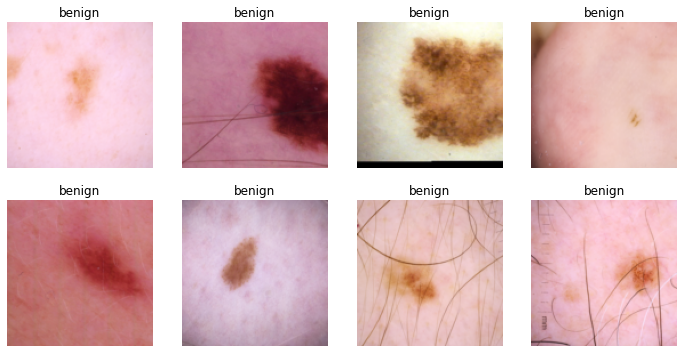

In [11]:
#create dataloaders object of class ImageDataLoaders from the sub_data df
jpg_path = '../input/siim-isic-melanoma-classification/jpeg'

dls = ImageDataLoaders.from_df(df = sub_data, #specify df holding image names
                               path = jpg_path,    #set path for where to find images
                               folder = 'train',   #specify looking specifically in the 'train' folder for this dls
                               suff = '.jpg',      #add the .jpg suffix to file names from df
                               label_col = 6,      #col 6 holds label info 'benign' or 'malignant'
                               valid_pct = 0.2,    #20% of images will be held for validation
                               bs = 8,            #set batch size
                               device=device,      #set device
                               item_tfms = Resize(128))    #resize images as they're loaded

dls.show_batch()

In [12]:
#create the vision learner

learn = vision_learner(dls,                  #specify dataloader object
                       resnet18,             #specify a pre-trained model we want to build off of
                       metrics=RocAucBinary, #specify metric we want to optimize
                       model_dir = '/kaggle/working')   #specify output location to store model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
#This cell is taking *way* too long to run, and not utilizing the GPU. 
#A forum search shows that others have run into the same issue with this dataset
#The CPU is being used to resize the images, which it turns out takes a long time
#The solution: resize the images prior to feeding them to the data learner.


#learn.lr_find()

The previous cell is taking *way* too long to run, and not utilizing the GPU. The cell below shows that the GPU is mounted and running, so why isn't it being used when I run the lr_find() method on the learner?

A forum search shows that others have run into the same issue with this dataset.\
The CPU is being used to resize the images in the DataLoader, which it turns out takes a long time.

The solution: resize the images prior to feeding them to the DataLoader.

In [14]:
print(torch.__version__)
print(fastai.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.backends.cudnn.enabled)
print(dls.device)

1.11.0
2.7.9
True
Tesla P100-PCIE-16GB
True
cuda:0


I want to resize all the images in ../jpeg to be a consistent size prior to feeding them into the data loader....how to do this?

idea 1: move copies of the images into my kaggle working directory and resize them there

idea 2: use a resized dataset someone else has already made (e.g. https://www.kaggle.com/datasets/sarques/siimisic-melanoma-1024jpeg) Note: tried these 1024x1024 files and running training the model ate up all my GPU capacity before even one epoch. Not a reasonable option in this environment. Instead, I'll try 224x224.

idea 3: can I somehow resize the images directly before feeding them to dls?

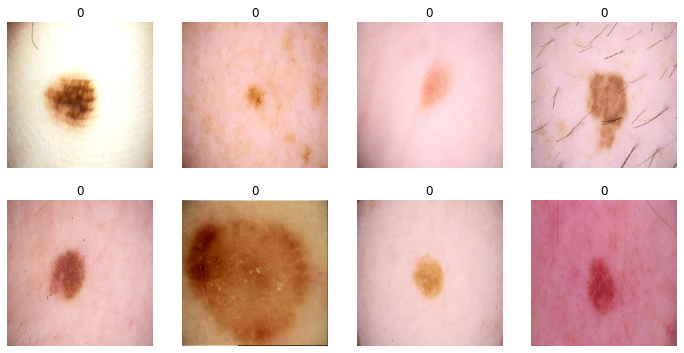

In [15]:
#try method 2 first, to see if I can get this working at all
#for this I actually ended up going with a 224 image size

path_224 = '../input/siic-isic-224x224-images'

dls2 = ImageDataLoaders.from_df(df = sub_data, #specify df holding image names
                               path = path_224,    #set path for where to find images
                               folder = 'train',   #specify looking specifically in the 'train' folder for this dls
                               suff = '.png',      #add the .png suffix to file names from df
                               label_col = 7,      #col 6 holds label info 0 or 1
                                seed = 42,
                                valid_pct = 0.2,
                               splitter=TrainTestSplitter (
                                   test_size=0.2,   #20% of images will be held for validation
                                   random_state=42, #set seed
                                   stratify=True,   #ensure a proportional split of classes in the train/test split
                                   shuffle=False),  #no indication that we should shuffle the data
                               bs = 8,            #set batch size
                               device=device)      #set device
                              # item_tfms = Resize(128))    #resize images as they're loaded

dls2.show_batch()

Now I can instantiate my first learner. [This resource](https://learnopencv.com/transfer-learning-for-medical-images/) on Transfer Learning for Medical Images from LearnOpenCV.com asserts that VGGNet pretrained models perform well for skin images in the medical context, so I'm going to leverage the vgg16_bn (batch normalized) pretrained model for my first pass.

I'm using the roc_auc_score metric because that is the basis the competition is scored on. It would also be very reasonable to use model recall as the primary metric, because we value avoiding false negatives when it comes to detecting deadly diseases. It it better to flag some lesions as malignant when they're not than to fail to detect lesions that are truly malignant. To be able to fully define the metrics of my model, I'm going to track roc_auc_score, error_rate (%of test samples incorrectly classified), and recall (TP/TP+FN, i.e. percentage of positive cases being accurately classified)

In [16]:
#instantiate the rocaucbinary metric
rocAucBinary = RocAucBinary()
recall = Recall()

#create the vision learner

learn2 = vision_learner(dls2,                  #specify dataloader object
                       models.vgg16_bn,             #specify a pre-trained model we want to build off of
                       metrics=[rocAucBinary, error_rate, recall], #specify metrics we want to see
                       model_dir = '/kaggle/working')   #specify output location to store model

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

A good first step before training the model is to gauge an appropriate learning rate to begin with. FastAI has a great built-in utility for this: lr_find. This function will default to using the "valley" algorithm as the suggested hyperparameter, but others are included as well. The topic of choosing the learning rate for a deep learning model is complex, with many theories existing. Ultimately, my impression as a novice is that it kind of comes down to being an art. Setting the learning rate too high risks missing out on finding the true gradient descent, setting the learning rate lower increases the processing time. There's a sweet spot in the middle.

Here are what the different suggestion functions are for FastAI's .lr_find():

   - [Valley](https://docs.fast.ai/callback.schedule.html#valley): Suggests a learning rate from the longest valley and returns its index. The valley algorithm was developed by ESRI and takes the steepest slope roughly 2/3 through the longest valley in the LR plot, and is also the default for Learner.lr_find
    
   - [Slide](https://docs.fast.ai/callback.schedule.html#slide): Suggests a learning rate following an interval slide rule and returns its index. The slide rule is an algorithm developed by Andrew Chang out of Novetta.
   
   - [Minimum](https://docs.fast.ai/callback.schedule.html#minimum): Suggests a learning rate one-tenth the minumum before divergance and returns its index
   
   - [Steep](https://docs.fast.ai/callback.schedule.html#steep): Suggests a learning rate when the slope is the steepest and returns its index

Minimum/10:	1.74e-02
Steepest point:	9.12e-07
Longest valley:	3.02e-03
Slide interval:	1.45e-03


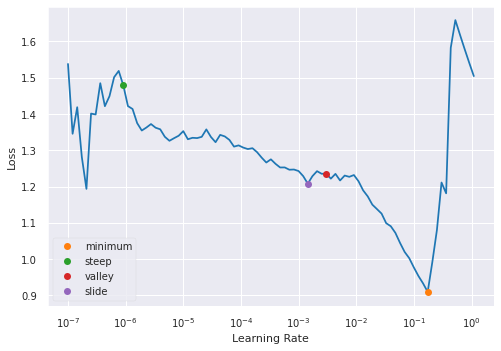

In [17]:
minimum, steep, valley, slide = learn2.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f"Minimum/10:\t{minimum:.2e}\nSteepest point:\t{steep:.2e}\nLongest valley:\t{valley:.2e}\nSlide interval:\t{slide:.2e}")

My artistic sensibilities are driving me to **use the learning rate found by the "minimum"** in this case. 

**Now I am ready to fine-tune the VGG16 pre-trained model.** FastAI's .fine_tune() method automates a lot of the steps of freezing/unfreezing layers, changing weights, and updating learning rates in the last few layers of the pre-trained model, leading to great results in most cases.

After some experimentation, **I've opted to use the SaveModelCallback() function** in the fine-tuning callbacks. What this does is evaluate the model performance against a set metric after each epoch. When there is an improvement in performance, the model is saved to the working directory. Using this method, I can ensure that the best epoch in model training is the one that is saved.

In [18]:
#set up a 10 epoch fine-tuning run

learn2.fine_tune(10,                               #set number of epochs 
                 base_lr=minimum,                  #set the initial learning rate
                 cbs=SaveModelCallback(            #use the SaveModelCallback to save the best model
                     monitor='roc_auc_score',      #set the roc_auc_score as the montitored metric
                     fname = 'vgg16_subset',       #choose the name the best model will be saved under
                     comp = np.greater,            #specify that when the roc_auc_score increases, that's considered better
                     with_opt=True))               #saves optimizer state, if available, when saving model

epoch,train_loss,valid_loss,roc_auc_score,error_rate,recall_score,time
0,0.373474,0.288828,0.523750,0.030303,0.000000,00:10


Better model found at epoch 0 with roc_auc_score value: 0.5237499999999999.


epoch,train_loss,valid_loss,roc_auc_score,error_rate,recall_score,time
0,0.156071,0.379478,0.470000,0.030303,0.000000,00:13
1,0.182875,0.381793,0.642500,0.066667,0.200000,00:13
2,0.208443,0.344716,0.532500,0.030303,0.000000,00:13
3,0.157636,0.245443,0.578750,0.030303,0.000000,00:14
4,0.228071,0.324064,0.510000,0.030303,0.000000,00:13
5,0.162365,0.296457,0.662500,0.030303,0.000000,00:13
6,0.123388,0.192829,0.672500,0.030303,0.000000,00:13
7,0.201241,0.183705,0.750000,0.030303,0.000000,00:13
8,0.122216,0.197749,0.707500,0.030303,0.000000,00:13
9,0.087895,0.191813,0.701250,0.030303,0.000000,00:13


Better model found at epoch 0 with roc_auc_score value: 0.47000000000000003.
Better model found at epoch 1 with roc_auc_score value: 0.6425000000000001.
Better model found at epoch 5 with roc_auc_score value: 0.6625000000000001.
Better model found at epoch 6 with roc_auc_score value: 0.6725.
Better model found at epoch 7 with roc_auc_score value: 0.75.


For the vgg16_bn pre-trained model, fine-tuning over 10 epochs leads to a max roc_auc_score of 0.75 after epoch 6. The best model has been saved as "vgg16_subset.pth" in the kaggle working directory.
The error rate is basically stable at only 3%, but the recall score is consistently 0, indicating that the model isn't correctly classifying the positive cases in the validation set. This is good starting place, but I definitely want to improve that performance.

The very top teams for this competition were able to achieve roc_auc scores of 0.95 in their submission.

What can I tinker with?

    1. which pre-trained model I start with
    2. batch size
    3. learning rate
    4. the proportion and quantity of malignant images the model is allowed to train on
    5. Preprocessing steps with the images; I could try transformations like random croping, rotation, using grayscale, etc.
    6. The loss function used in fine-tuning
   
**First, I'm going to jump over to ResNet34 and see how that does.**
ResNet is a versatile pretrained image model that applies well to a variety of use-cases. It's worth a try to see how it compares to VGG16

In [23]:
#leverage the resnet34 pretrained CNN model
learn3 = vision_learner(dls2,                  #specify dataloader object
                       models.resnet34,             #specify a pre-trained model we want to build off of
                       metrics=[rocAucBinary, error_rate, recall], #specify metric we want to optimize
                       model_dir = '/kaggle/working')   #specify output location to store model

In [28]:
learn3.lr_find(suggest_funcs=(minimum, steep, valley, slide))

AttributeError: 'float' object has no attribute '__name__'

In [29]:
#use the valley method to set the base_lr: 0.04786301031708717
learn3.fine_tune(10, 
                 base_lr=0.04786301031708717, 
                 cbs=SaveModelCallback(
                     monitor='roc_auc_score', 
                     fname = 'resnet34_subset', 
                     comp = np.greater, 
                     with_opt=True))

epoch,train_loss,valid_loss,roc_auc_score,error_rate,recall_score,time
0,0.807926,1.488080,0.333750,0.036364,0.000000,00:07


Better model found at epoch 0 with roc_auc_score value: 0.33375.


epoch,train_loss,valid_loss,roc_auc_score,error_rate,recall_score,time
0,0.368919,0.701995,0.738750,0.030303,0.000000,00:09
1,0.385129,1.075165,0.636250,0.030303,0.000000,00:10
2,0.480732,9.096248,0.320000,0.030303,0.000000,00:09
3,0.578197,0.746365,0.576250,0.030303,0.000000,00:08
4,0.576947,0.504845,0.670000,0.030303,0.000000,00:09
5,0.350376,483.300720,0.546875,0.030303,0.000000,00:09
6,0.319960,110.075920,0.543750,0.030303,0.000000,00:08
7,0.366683,12.025895,0.578750,0.042424,0.000000,00:08
8,0.249542,23.809227,0.551250,0.042424,0.000000,00:09
9,0.259838,0.223123,0.775000,0.024242,0.200000,00:08


Better model found at epoch 0 with roc_auc_score value: 0.73875.
Better model found at epoch 9 with roc_auc_score value: 0.775.


The highest roc_auc_score for the resnet 34 based-model reached 0.775 after epoch 9. The fine-tuned model has an error rate of just 2.4%, however only scores a recall of 0.2. The epochs trained more quickly, in under 10s for each epoch v. the 13s per epoch when using the vgg16_bn model. While fine-tuning the ResNet34 model, the validation loss was really high and "all over the place" for epochs 5-8, but then drastically improved for the final epoch, 9.

**Conclusion:** resnet34 is achieving higher performance with this particular training and validation set (reminder: this is only 2.5% of the overall training data, and only being validated on 0.5% of the overall training data), and does so with lower computational cost. **It's my best model, for now**

## Part IV: Use the best model to make predictions for the submission.

Here are the submission guidelines for the Kaggle competition:

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

Submission File
For each image_name in the test set, you must predict the probability (target) that the sample is malignant. The file should contain a header and have the following format:

image_name,target

ISIC_0052060,0.7

ISIC_0052349,0.9

ISIC_0058510,0.8

ISIC_0073313,0.5

ISIC_0073502,0.5

etc.


In [30]:
#load the resnet34 learner as "best_model"
best_model = learn3.load('resnet34_subset', #load model from working directory
                         device=device,     #ensure the loaded model uses the active cuda:0 device
                         with_opt=True,     #load optimizer state
                         strict=True)       #the file must exactly contain weights for every parameter key in model

#read in test csv
test = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

In [31]:
#Initialize a list of image names containing all the images from test
test_ims = test['image_name'].to_list()
print(f"number of test images: {len(test_ims)}")

#initialize a dict to hold results
preds = {}


number of test images: 10982


In [40]:
#test_path
test_path = '../input/siic-isic-224x224-images/test/'

test_dl = dls2.test_dl(get_image_files(test_path))

predictions = best_model.get_preds(dl=test_dl, with_preds=True)

In [46]:
predictions

(TensorBase([[9.9991e-01, 9.4753e-05],
         [9.9987e-01, 1.3259e-04],
         [1.0000e+00, 0.0000e+00],
         ...,
         [9.9990e-01, 1.0099e-04],
         [1.0000e+00, 4.8057e-12],
         [9.9996e-01, 3.8415e-05]]),
 None)

In [53]:
#this would work if we were just predicting on 1 image
#categories = ('Benign', 'Malignant')

#def classify_image(img):
#    pred, idx, probs = best_model.predict(img)
#    return dict(zip(categories, map(float,probs)))

In [64]:
#initialize a dict to hold results
preds = {}


#update keys in dict to hold likelihood
for i in range(len(test_ims)):
    preds[test_ims[i]] = np.round(float(predictions[0][i][1]),1) #gives the likelihood of an image being malignant

In [75]:
submission = pd.DataFrame.from_dict(preds, orient='index')
submission.reset_index(inplace=True)
submission.rename(columns={'index':'image_name',0:'target'},inplace=True)

submission.to_csv("submission.csv", index=False)
submission.head()


,image_name,target
0,ISIC_0052060,0.0
1,ISIC_0052349,0.0
2,ISIC_0058510,0.0
3,ISIC_0073313,0.0
4,ISIC_0073502,0.0


In [76]:
#check to make sure output looks like I want it to. Looks good.
pd.read_csv('./submission.csv').head()

,image_name,target
0,ISIC_0052060,0.0
1,ISIC_0052349,0.0
2,ISIC_0058510,0.0
3,ISIC_0073313,0.0
4,ISIC_0073502,0.0


Submission scores
Private: .5081
Public: .4928

## Part V: export the best model as a pkl file

In [36]:
#this exports the model to the kaggle working directory. 
#From there I have to download it to my local device so I can use it for deployment.
best_model.export('/kaggle/working/resnet34_subsample_proportional.pkl')

## Part 6: Next steps

Now that I have a working prototype that is performing reasonably well on a small subset of the data, I have a couple of avenues to work on next.
    
    1. Set up a site to deploy the model on. I'm going to follow the instructions given by Jeremy Howard in [Practical Deep Learning for Coders, Lesson 2: Deployment](https://course.fast.ai/Lessons/lesson2.html)
    
    2. Build a working model on a larger set of the data. Because I'm not building from scratch, it may make more sense to get a balanced sample of the ~500 malignant images and an equal number of benign images. I'm not sure yet, and I do think this will take some experimentation.
    
    3. Create my own image dataset with resized images and upload to kaggle. This will give me greater ownership of the project from start to finish, as I'll be writing the Python code to resize the images on my local machine. 